By Drilon & Chia-Hua

In [1]:
import glob
import os
import string

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from sklearn.metrics import confusion_matrix

### Load Data

The names can be found in text files in a src directory, one file per language.

In the following you can find some utilities to load the data into pandas data frames. 

We will restrict to some common European languages. 

With the given selection, we will identify all the occurring characters and initialize an alphabet.<br>
For this alphabet, we will use a one-hot-encoding to map them into a vector space representation. 

Foresee a suitable character for the end of the word, e.g. 'END'.

In [2]:
srcdir = 'data/names'
languages = ["English","French","Italian","German","Spanish"]

In [3]:
# inspect the data directory
def findFiles(path): 
    return glob.glob(path)

In [4]:
print('\n'.join(findFiles(os.path.join(srcdir,'*.txt'))))

data/names/French.txt
data/names/Dutch.txt
data/names/Vietnamese.txt
data/names/Scottish.txt
data/names/Japanese.txt
data/names/Spanish.txt
data/names/Korean.txt
data/names/Irish.txt
data/names/Polish.txt
data/names/Russian.txt
data/names/Italian.txt
data/names/Greek.txt
data/names/Arabic.txt
data/names/Czech.txt
data/names/English.txt
data/names/Portuguese.txt
data/names/Chinese.txt
data/names/German.txt


In [5]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

def load_data(srcdir, categories=None):
    names_list = []
    for filename in findFiles(os.path.join(srcdir,'*.txt')):
        category = os.path.splitext(os.path.basename(filename))[0]
        if not categories or category in categories: 
            names = readLines(filename)
            names_list.extend([(name,category) for name in names])
    df = pd.DataFrame(names_list)
    df.columns = ["name","lang"]
    return df

In [6]:
names = load_data(srcdir,categories=languages)
names.head()

,name,lang
0,Abel,French
1,Abraham,French
2,Adam,French
3,Albert,French
4,Allard,French


In [7]:
maxlen = np.max([len(name) for name in names.name])
print("Maximum name length: ", maxlen)

Maximum name length:  18


In [8]:
alphabet = sorted(list(set(''.join([name for name in names.name]))))
alphabet.append('END')
len_alphabet = len(alphabet)
char_index = dict((c, i) for i, c in enumerate(alphabet))
print("Size of alphabet: ",len_alphabet)
print(alphabet)

Size of alphabet:  74
[' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'É', 'ß', 'à', 'á', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'ö', 'ù', 'ú', 'ü', 'END']


In [9]:
names.groupby('lang')['name'].count()/len(names)

lang
English    0.646230
French     0.048802
German     0.127555
Italian    0.124912
Spanish    0.052502
Name: name, dtype: float64

### Vector Representations

Now construct the vector representation by using one-hot-vectors. 

In [10]:
language_to_index = {country:index for index,country in enumerate(names.lang.unique())}
index_to_language = {index:country for index,country in enumerate(names.lang.unique())}

def onehot(i, length):
    v = np.zeros(length)
    v[i] = 1
    return v

def name_representation(name, maxlen):
    ### START YOUR CODE
    name_trunc = str(name)[0:maxlen]
    size = len(char_index)
    vector = [onehot(char_index[j], size) for j in str(name_trunc)]
    # fill the rest with 
    for k in range(0,maxlen - len(str(name_trunc))):
        vector.append(onehot(char_index['END'], size))
    return vector
    ### START YOUR CODE

def lang_representation(language, language_to_index):
    y = np.zeros(len(language_to_index))
    y[language_to_index[language]]=1
    return y

def lang_from_output(score):
    return index_to_language[np.argmax(score)]

def predict(name, model):
    score = model.predict(np.array([name_representation(name, maxlen)]))[0]
    return lang_from_output(score)

### Prepare train/test

Split the data into train/test

Shuffle the data

Transform the names data into a suitable vector representation:
* names into numpy arrays of shape (*,maxlen,len_alphabet)
* language into numpy array of shape (*,len(languages))



In [11]:
# Map train and test data into vector space (one-hot-vectors)
names['name_vector'] = names['name'].apply(lambda x: name_representation(x, maxlen))

# Transform languages to one-hot vectors
names['lang_vector'] = names['lang'].apply(lambda x: lang_representation(x, language_to_index))

# Convert lists of one-hot vectors to numpy arrays
names['name_vector'] = names['name_vector'].apply(lambda x: np.array(x))
names['lang_vector'] = names['lang_vector'].apply(lambda x: np.array(x))

test_split = 0.2

### START YOUR CODE
# Shuffle and split names data

train = names.sample(frac=0.8, random_state=666)

test = names.drop(train.index)

### END YOUR CODE

In [12]:

X_train = np.array(list(train['name_vector']))
Y_train = np.array(list(train['lang_vector']))

X_test = np.array(list(test['name_vector']))
Y_test = np.array(list(test['lang_vector']))

### END YOUR CODE

In [18]:
print(X_train.shape)
print(Y_train.shape)

(4541, 18, 74)
(4541, 5)


Possibly, pack the data into a Dataset (e.g. when working with in PyTorch)

### Define and Train Model: Single Layer with SimpleRNN

Create an RNN consisting of a single layer with a SimpleRNN (keras) and a softmax.

Then train the model. Play with different number of hidden units in the layer to obtain a good accuracy.

In [20]:
from keras import Sequential, layers

In [24]:
### START YOUR CODE

# SimpleRNN, single layer with tf.keras....

model = Sequential()
model.add(layers.SimpleRNN(units=15, input_shape=(maxlen, len_alphabet)))
model.add(layers.Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

### END YOUR CODE

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 15)                1350      
                                                                 
 dense_1 (Dense)             (None, 5)                 80        
                                                                 
Total params: 1,430
Trainable params: 1,430
Non-trainable params: 0
_________________________________________________________________


In [32]:
def plot_performance(model_log):
    f = plt.figure(figsize=(12,4))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.plot(model_log.history['loss'], label='Training loss')
    ax1.plot(model_log.history['val_loss'], label='Testing loss')
    ax1.legend()
    ax1.grid()
    ax2.plot(model_log.history['accuracy'], label='Training acc')
    ax2.plot(model_log.history['val_accuracy'], label='Testing acc')
    ax2.legend()
    ax2.grid()

Epoch 1/50
71/71 [==============================] - 1s 16ms/step - loss: 0.6061 - accuracy: 0.7831 - val_loss: 0.7171 - val_accuracy: 0.7507
Epoch 2/50
71/71 [==============================] - 1s 20ms/step - loss: 0.6072 - accuracy: 0.7804 - val_loss: 0.7278 - val_accuracy: 0.7515
Epoch 3/50
71/71 [==============================] - 2s 21ms/step - loss: 0.5982 - accuracy: 0.7842 - val_loss: 0.7179 - val_accuracy: 0.7559
Epoch 4/50
71/71 [==============================] - 1s 18ms/step - loss: 0.5984 - accuracy: 0.7844 - val_loss: 0.7209 - val_accuracy: 0.7524
Epoch 5/50
71/71 [==============================] - 2s 22ms/step - loss: 0.5914 - accuracy: 0.7871 - val_loss: 0.7245 - val_accuracy: 0.7568
Epoch 6/50
71/71 [==============================] - 1s 17ms/step - loss: 0.5920 - accuracy: 0.7879 - val_loss: 0.7218 - val_accuracy: 0.7586
Epoch 7/50
71/71 [==============================] - 1s 16ms/step - loss: 0.5829 - accuracy: 0.7908 - val_loss: 0.7276 - val_accuracy: 0.7586
Epoch 8/50
71

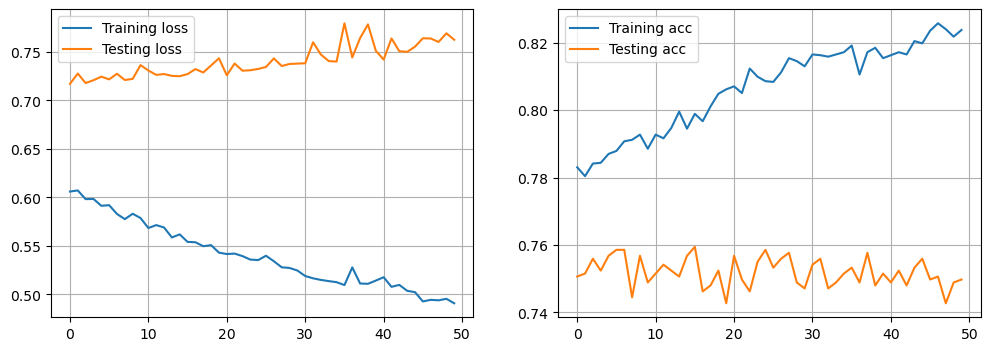

In [29]:
### START YOUR CODE
batch_size= 64
nepochs = 50

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nepochs, validation_data=(X_test, Y_test))
plot_performance(log)
### END YOUR CODE

In [30]:
def build_and_train_model(X_train, Y_train, X_test, Y_test, rnn_units=15, rnn_layers=1, dense_units=5, batch_size=64, nepochs=50):

    model = Sequential()
    for i in range(rnn_layers):
        if i == 0:
            model.add(layers.SimpleRNN(rnn_units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < rnn_layers - 1)))
        else:
            model.add(layers.SimpleRNN(rnn_units, return_sequences=(i < rnn_layers - 1)))

    model.add(layers.Dense(dense_units, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nepochs, validation_data=(X_test, Y_test))

    return model, history

Epoch 1/50
71/71 [==============================] - 4s 40ms/step - loss: 1.1741 - accuracy: 0.6228 - val_loss: 1.1169 - val_accuracy: 0.6264
Epoch 2/50
71/71 [==============================] - 1s 18ms/step - loss: 1.0514 - accuracy: 0.6512 - val_loss: 1.0470 - val_accuracy: 0.6326
Epoch 3/50
71/71 [==============================] - 1s 21ms/step - loss: 0.9780 - accuracy: 0.6569 - val_loss: 0.9737 - val_accuracy: 0.6581
Epoch 4/50
71/71 [==============================] - 2s 34ms/step - loss: 0.9015 - accuracy: 0.6794 - val_loss: 0.9073 - val_accuracy: 0.6784
Epoch 5/50
71/71 [==============================] - 2s 22ms/step - loss: 0.8312 - accuracy: 0.7043 - val_loss: 0.8510 - val_accuracy: 0.6969
Epoch 6/50
71/71 [==============================] - 1s 18ms/step - loss: 0.7867 - accuracy: 0.7214 - val_loss: 0.8136 - val_accuracy: 0.7207
Epoch 7/50
71/71 [==============================] - 3s 36ms/step - loss: 0.7509 - accuracy: 0.7335 - val_loss: 0.8011 - val_accuracy: 0.7172
Epoch 8/50
71

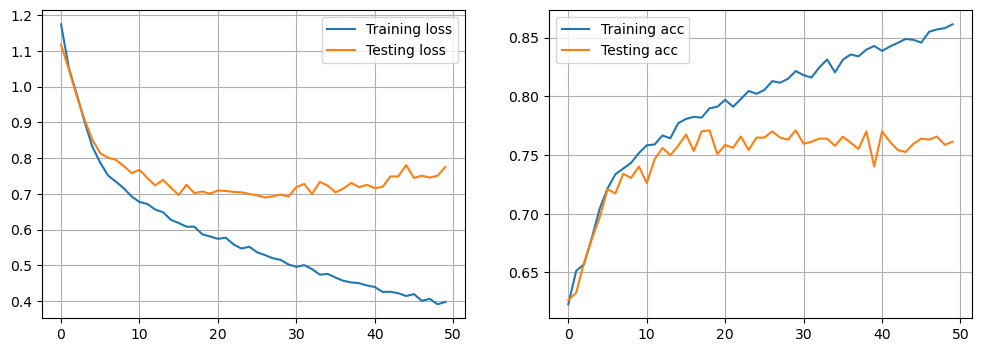

In [33]:
more_units_model, more_units_log = build_and_train_model(X_train, Y_train, X_test,Y_test, rnn_units=30, rnn_layers=1)
plot_performance(more_units_log)

Epoch 1/50
36/36 [==============================] - 3s 53ms/step - loss: 1.2515 - accuracy: 0.5657 - val_loss: 1.1580 - val_accuracy: 0.6264
Epoch 2/50
36/36 [==============================] - 1s 40ms/step - loss: 1.0899 - accuracy: 0.6516 - val_loss: 1.1069 - val_accuracy: 0.6264
Epoch 3/50
36/36 [==============================] - 1s 34ms/step - loss: 1.0570 - accuracy: 0.6540 - val_loss: 1.0578 - val_accuracy: 0.6326
Epoch 4/50
36/36 [==============================] - 1s 30ms/step - loss: 0.9784 - accuracy: 0.6754 - val_loss: 0.9473 - val_accuracy: 0.6670
Epoch 5/50
36/36 [==============================] - 2s 49ms/step - loss: 0.8813 - accuracy: 0.6996 - val_loss: 0.8679 - val_accuracy: 0.6969
Epoch 6/50
36/36 [==============================] - 1s 33ms/step - loss: 0.8235 - accuracy: 0.7131 - val_loss: 0.8277 - val_accuracy: 0.6987
Epoch 7/50
36/36 [==============================] - 1s 35ms/step - loss: 0.7857 - accuracy: 0.7291 - val_loss: 0.8106 - val_accuracy: 0.7101
Epoch 8/50
36

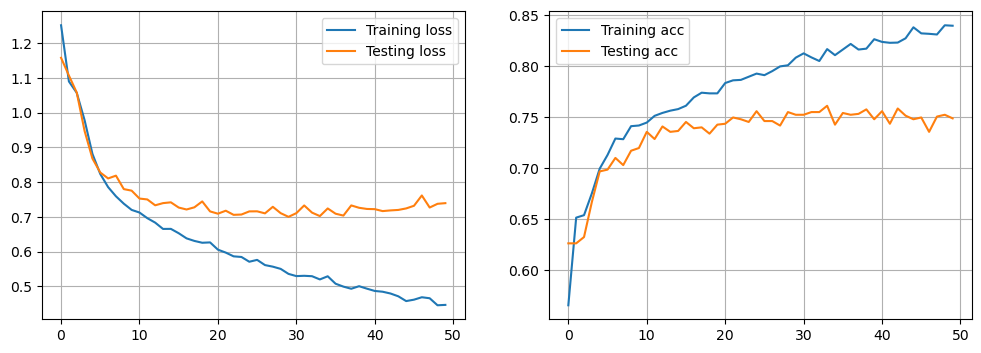

In [35]:
greater_bsize_model, greater_bsize_log = build_and_train_model(X_train, Y_train, X_test,Y_test, rnn_units=30, rnn_layers=1, batch_size=128)
plot_performance(greater_bsize_log)

Epoch 1/50
36/36 [==============================] - 3s 58ms/step - loss: 1.1386 - accuracy: 0.6320 - val_loss: 1.0791 - val_accuracy: 0.6326
Epoch 2/50
36/36 [==============================] - 1s 32ms/step - loss: 0.9817 - accuracy: 0.6684 - val_loss: 0.9154 - val_accuracy: 0.6855
Epoch 3/50
36/36 [==============================] - 1s 25ms/step - loss: 0.8469 - accuracy: 0.7054 - val_loss: 0.8265 - val_accuracy: 0.7128
Epoch 4/50
36/36 [==============================] - 1s 26ms/step - loss: 0.7815 - accuracy: 0.7230 - val_loss: 0.7913 - val_accuracy: 0.7154
Epoch 5/50
36/36 [==============================] - 1s 28ms/step - loss: 0.7396 - accuracy: 0.7355 - val_loss: 0.7737 - val_accuracy: 0.7330
Epoch 6/50
36/36 [==============================] - 1s 23ms/step - loss: 0.7105 - accuracy: 0.7430 - val_loss: 0.7402 - val_accuracy: 0.7401
Epoch 7/50
36/36 [==============================] - 1s 23ms/step - loss: 0.6814 - accuracy: 0.7496 - val_loss: 0.7468 - val_accuracy: 0.7286
Epoch 8/50
36

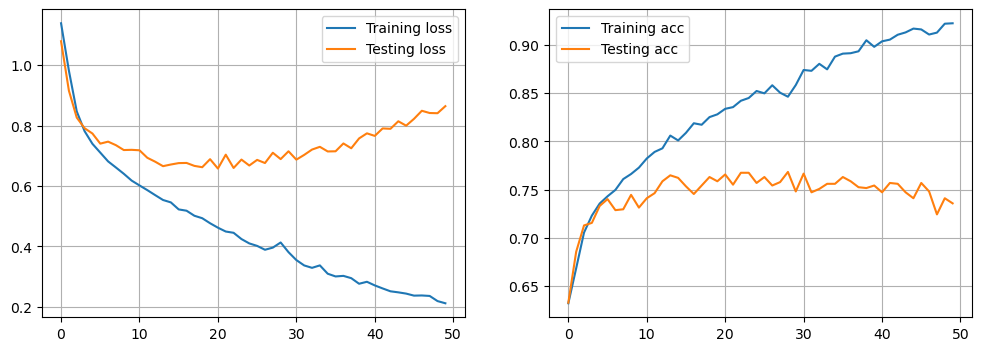

In [36]:
greater_model, greater_log = build_and_train_model(X_train, Y_train, X_test,Y_test, rnn_units=60, rnn_layers=1, batch_size=128)
plot_performance(greater_log)

#### Findings

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

36/36 [==============================] - 1s 16ms/step


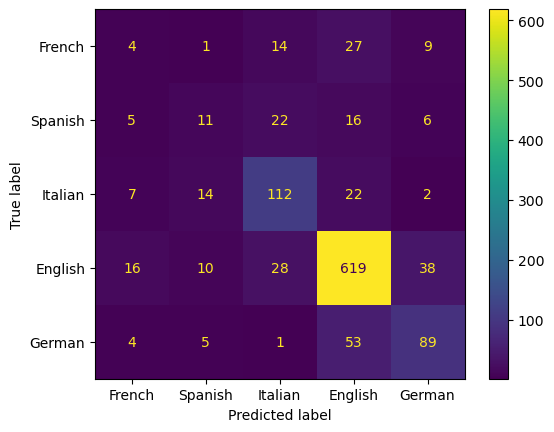

In [50]:
y_pred = greater_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(Y_test, axis=1)

class_labels = [index_to_language[i] for i in sorted(index_to_language)]

cm = confusion_matrix(y_true, y_pred_classes, labels=range(len(class_labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()

### Implement Model with several SimpleRNN Layers

Epoch 1/50
71/71 [==============================] - 8s 77ms/step - loss: 1.1595 - accuracy: 0.6074 - val_loss: 1.1026 - val_accuracy: 0.6273
Epoch 2/50
71/71 [==============================] - 3s 47ms/step - loss: 1.0173 - accuracy: 0.6613 - val_loss: 0.9851 - val_accuracy: 0.6670
Epoch 3/50
71/71 [==============================] - 4s 60ms/step - loss: 0.8672 - accuracy: 0.6996 - val_loss: 0.8651 - val_accuracy: 0.6925
Epoch 4/50
71/71 [==============================] - 5s 64ms/step - loss: 0.7859 - accuracy: 0.7208 - val_loss: 0.8155 - val_accuracy: 0.7154
Epoch 5/50
71/71 [==============================] - 5s 65ms/step - loss: 0.7433 - accuracy: 0.7302 - val_loss: 0.7717 - val_accuracy: 0.7401
Epoch 6/50
71/71 [==============================] - 3s 49ms/step - loss: 0.6961 - accuracy: 0.7487 - val_loss: 0.7621 - val_accuracy: 0.7225
Epoch 7/50
71/71 [==============================] - 4s 54ms/step - loss: 0.6769 - accuracy: 0.7562 - val_loss: 0.7410 - val_accuracy: 0.7436
Epoch 8/50
71

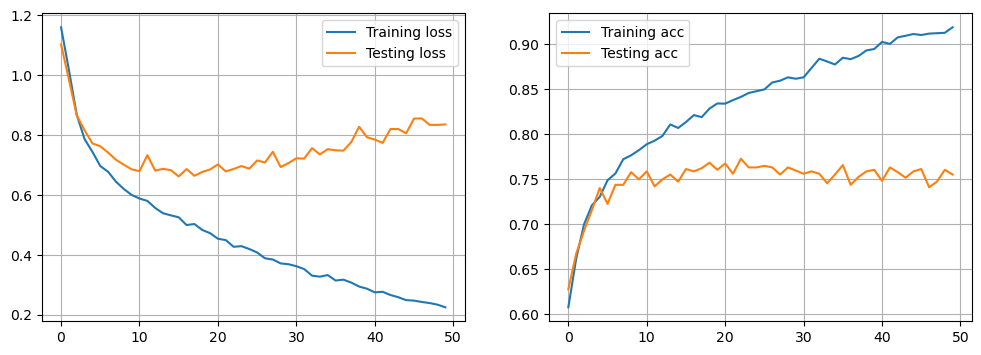

In [52]:
two_layer_RNN_model, two_layer_RNN_log = build_and_train_model(X_train, Y_train, X_test,Y_test, rnn_units=30, rnn_layers=2, batch_size=64)
plot_performance(two_layer_RNN_log)

Epoch 1/50
71/71 [==============================] - 10s 92ms/step - loss: 1.1161 - accuracy: 0.6410 - val_loss: 1.0883 - val_accuracy: 0.6308
Epoch 2/50
71/71 [==============================] - 5s 75ms/step - loss: 0.9930 - accuracy: 0.6644 - val_loss: 0.9404 - val_accuracy: 0.6678
Epoch 3/50
71/71 [==============================] - 5s 68ms/step - loss: 0.8656 - accuracy: 0.6952 - val_loss: 0.8632 - val_accuracy: 0.6846
Epoch 4/50
71/71 [==============================] - 5s 72ms/step - loss: 0.7734 - accuracy: 0.7232 - val_loss: 0.7910 - val_accuracy: 0.7181
Epoch 5/50
71/71 [==============================] - 5s 69ms/step - loss: 0.7241 - accuracy: 0.7401 - val_loss: 0.8051 - val_accuracy: 0.7154
Epoch 6/50
71/71 [==============================] - 4s 63ms/step - loss: 0.6772 - accuracy: 0.7553 - val_loss: 0.7400 - val_accuracy: 0.7295
Epoch 7/50
71/71 [==============================] - 4s 63ms/step - loss: 0.6342 - accuracy: 0.7699 - val_loss: 0.6994 - val_accuracy: 0.7445
Epoch 8/50
7

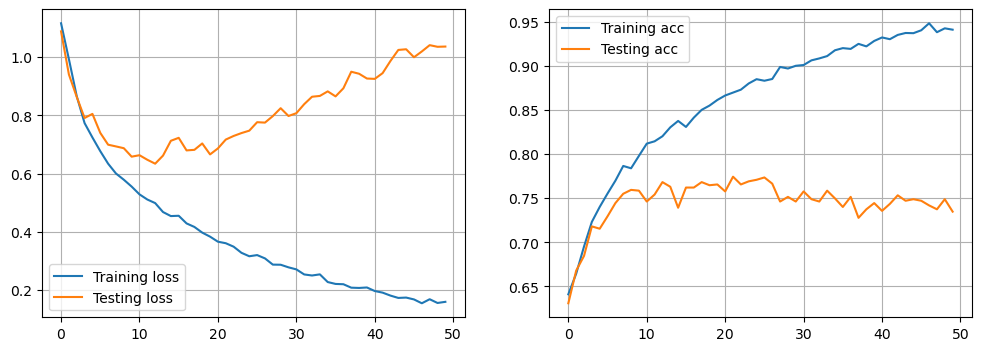

In [53]:
three_layer_RNN_model, three_layer_RNN_log = build_and_train_model(X_train, Y_train, X_test,Y_test, rnn_units=30, rnn_layers=3, batch_size=64)
plot_performance(three_layer_RNN_log)

Epoch 1/50
71/71 [==============================] - 10s 88ms/step - loss: 1.1549 - accuracy: 0.6285 - val_loss: 1.1015 - val_accuracy: 0.6300
Epoch 2/50
71/71 [==============================] - 5s 77ms/step - loss: 0.9807 - accuracy: 0.6763 - val_loss: 0.9226 - val_accuracy: 0.6872
Epoch 3/50
71/71 [==============================] - 5s 77ms/step - loss: 0.8390 - accuracy: 0.7164 - val_loss: 0.8248 - val_accuracy: 0.7260
Epoch 4/50
71/71 [==============================] - 6s 84ms/step - loss: 0.7657 - accuracy: 0.7355 - val_loss: 0.7809 - val_accuracy: 0.7251
Epoch 5/50
71/71 [==============================] - 5s 76ms/step - loss: 0.7223 - accuracy: 0.7439 - val_loss: 0.7683 - val_accuracy: 0.7278
Epoch 6/50
71/71 [==============================] - 6s 84ms/step - loss: 0.6671 - accuracy: 0.7602 - val_loss: 0.7433 - val_accuracy: 0.7410
Epoch 7/50
71/71 [==============================] - 5s 76ms/step - loss: 0.6398 - accuracy: 0.7686 - val_loss: 0.7093 - val_accuracy: 0.7533
Epoch 8/50
7

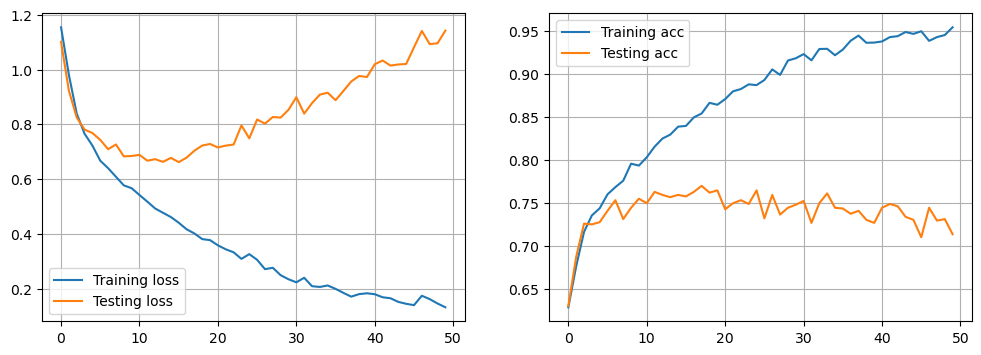

In [54]:
four_layer_RNN_model, four_layer_RNN_log = build_and_train_model(X_train, Y_train, X_test,Y_test, rnn_units=30, rnn_layers=4, batch_size=64)
plot_performance(four_layer_RNN_log)

36/36 [==============================] - 1s 20ms/step


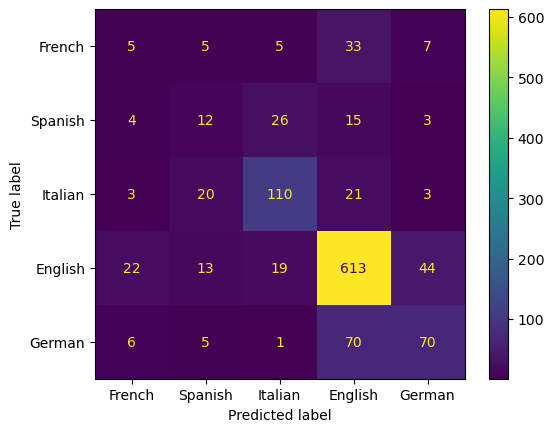

In [55]:
y_pred = four_layer_RNN_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(Y_test, axis=1)

class_labels = [index_to_language[i] for i in sorted(index_to_language)]

cm = confusion_matrix(y_true, y_pred_classes, labels=range(len(class_labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()

#### Findings

We attempted to improve our model's performance by stacking multiple RNN layers, but unfortunately, this approach did not lead to an increase in accuracy. Additionally, the confusion matrix did not show any significant improvements from this modification. Despite these efforts, the model's ability to predict the correct languages remains unchanged, suggesting that other strategies might be needed to enhance its predictive power.

### Class Imbalance Handling

Choose a method to address the class imbalance seen in the given example.
- minority resampling 
- class weights in the loss

Implement it and incorporate it in the training.
Evaluate the results and compare it with the results obtained with the unbalanced training.  

In [58]:
print(X_train[0])
print(Y_train[0])

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[0. 0. 1. 0. 0.]


Unique classes after resampling: [0 1 2 3 4]
Number of unique classes: 5
Epoch 1/50
232/232 [==============================] - 10s 33ms/step - loss: 1.3161 - accuracy: 0.4444 - val_loss: 1.2288 - val_accuracy: 0.4564
Epoch 2/50
232/232 [==============================] - 8s 34ms/step - loss: 0.9329 - accuracy: 0.6285 - val_loss: 1.0938 - val_accuracy: 0.5216
Epoch 3/50
232/232 [==============================] - 8s 34ms/step - loss: 0.7617 - accuracy: 0.7036 - val_loss: 0.9707 - val_accuracy: 0.6176
Epoch 4/50
232/232 [==============================] - 7s 31ms/step - loss: 0.6408 - accuracy: 0.7608 - val_loss: 1.1381 - val_accuracy: 0.5269
Epoch 5/50
232/232 [==============================] - 7s 32ms/step - loss: 0.5780 - accuracy: 0.7891 - val_loss: 1.0056 - val_accuracy: 0.6035
Epoch 6/50
232/232 [==============================] - 8s 36ms/step - loss: 0.4762 - accuracy: 0.8304 - val_loss: 1.0532 - val_accuracy: 0.6070
Epoch 7/50
232/232 [==============================] - 11s 49ms/step 

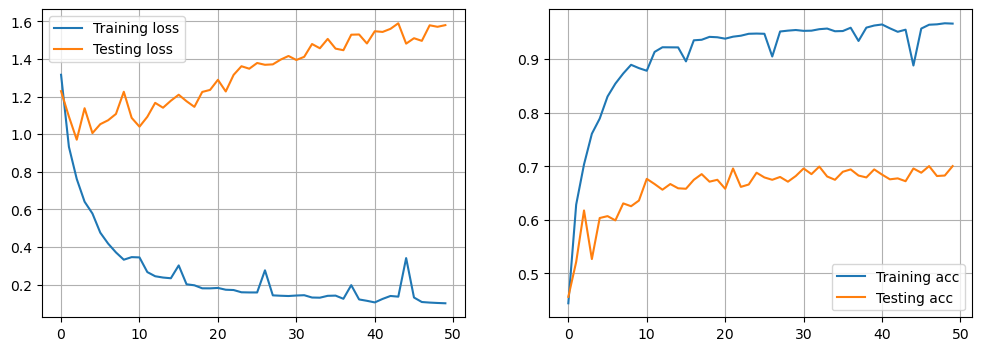

In [61]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

X_train_flattened = X_train.reshape(X_train.shape[0], -1)
y_train_labels = np.argmax(Y_train, axis=1)

ros = RandomOverSampler(random_state=42)
X_resampled_flattened, Y_resampled = ros.fit_resample(X_train_flattened, y_train_labels)

X_resampled = X_resampled_flattened.reshape(-1, X_train.shape[1], X_train.shape[2])

Y_resampled = np.eye(np.max(Y_resampled) + 1)[Y_resampled]
unique_classes = np.unique(np.argmax(Y_resampled, axis=1))
print("Unique classes after resampling:", unique_classes)
print("Number of unique classes:", len(unique_classes))

resampled_model, resampled_log = build_and_train_model(X_resampled, Y_resampled, X_test, Y_test, rnn_units=30, rnn_layers=2, 
                                                       dense_units=len(unique_classes), batch_size=64, nepochs=50)

plot_performance(resampled_log)

Somehow test accuracy got even worse after resampling, we would have expected a positive change in accuracy with resampling.